In [2]:
#imports
import pandas
import numpy
import os
import plotnine
from plotnine.data import *
import glob
from datetime import datetime
import math
from datetime import datetime
from time import sleep

In [3]:
#Changeable constants
my_path = "C:\\Users\\bhata\\Documents\\evhs-covid19\\src"

In [4]:
def plotData(data, x_data, y_data, colorKey, text_size = 14, graph_w = 20, graph_h = 10):
    myPlot = plotnine.ggplot(data)\
    + plotnine.aes(x = x_data, y = y_data, color=colorKey)\
    + plotnine.geom_line()
    myPlot.draw()

def combine_subsections(df, big_place, big_place_category="Country/Region", sub_place_category = "Province/State",\
                        new_big_place_name = "", new_sub_place_name = math.nan, lat = math.nan, long = math.nan,\
                        dates = [], include_actual_country=True):
    
    ret_data = pandas.DataFrame(columns = df.columns)
    if new_big_place_name == "":
        new_big_place_name = "Total Data for "+new_big_place_name #renames the country
    df2 = df[df[big_place_category]==big_place] #gets the data for the place
    
    if len(dates)==0:    
        dates = list(set(df2["Date"])) #gets the dates if they haven't been provided
    for date in dates: #iterates through each date
        #print(big_place_category, ": ", big_place, "  |  Date: ", date)
        df3 = df2[df2["Date"]==date] #gets the data for the place on that particular date 
        if include_actual_country == False:
            df3 = df3[df3[sub_place_category]==df3[sub_place_category]]
            #Both Denmark and the Faroe Islands have the country as Denmark
            #but the state for the Faroe Islands is the Faroe Islands, while the state for Denmark is nan
            #nan values don't equal themselves, so this filters out the main country
            #This logic holds for France, Britain, and the Netherlands as well

        value = [date, new_big_place_name, new_sub_place_name, lat, long, df3["Confirmed"].sum(), df3["Recovered"].sum(), \
                df3["Deaths"].sum()]
        #creates a list: [FIPS, admin2, state, country, latitude, longitude, confirmed, deaths, recovered, active, date]
        
        value = pandas.Series(data = value, index = df3.columns) #appends the list to the dataframe
        df = df.append(value, ignore_index = True) #appends the mini-dataframe to the main one
        ret_data = ret_data.append(value, ignore_index = True)
    return df, ret_data

def rounder(number, places):
    number = int(number * (10**places))
    return number / (10**places)
    

def moving_average(values, length, rounded = 2):
    if (length > len(values) ) or (length < 0):
        return math.nan
    else:
        ret = []
        for i in range( len(values)-length+1  ):
            avg = sum(values[ i:(length+i)  ])
            ret.append(rounder(avg/length, rounded))
        return ret

def cleaningCombinedDataForCountryOnly(country, minimum = 1):
    country = country.sort_values(by = ["Date"])
    country = country.reset_index(drop = True)
    country["Active"] = country["Confirmed"] - country["Recovered"]
    country = country[country["Confirmed"]>=minimum]
    country = country.reset_index(drop = True)
    country["Days"] = country.index
    return country


def getDoublingRates(country):
    doubling_rates = []
    doubling_rates.append(math.nan)
    for i in range(len(country)-1):
        rate = 2 * country.iloc[i]["Confirmed"] / (country.iloc[i+1]["Confirmed"] - country.iloc[i]["Confirmed"])
        rate = min(10**11, rate)
        if rate < 10**10:
            rate = rounder(rate, 3)
        else:
            rate = math.nan
        doubling_rates.append(rate)
    country["Days until Cases Double (at this Rate)"] = doubling_rates
    return country

C:\Users\bhata\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\bhata\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:74: UserWarning: geom_path: Removed 6 rows containing missing values.
  warn(msg.format(n1-n2))


Index(['Date', 'Country/Region', 'Province/State', 'Lat', 'Long', 'Confirmed',
       'Recovered', 'Deaths', 'Active', 'Days',
       'Days until Cases Double (at this Rate)'],
      dtype='object')

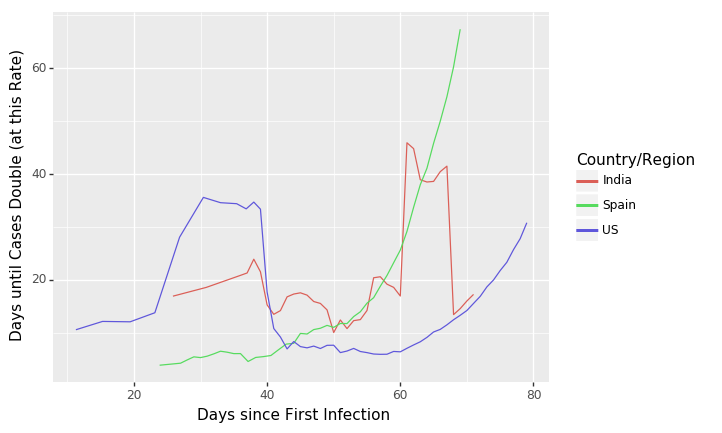

In [13]:
os.chdir(my_path)
file = glob.glob("*.csv")[0]
data = pandas.read_csv(file)


data1 = pandas.DataFrame()

countries_of_interest = {"India":[20.5937, 78.9629], "US":[37.0902, 95.7129], "Spain":[40.4637, 3.7492]}
#countries_of_interest = ["India", "US", "Spain"]

for i in countries_of_interest:
    x, country = combine_subsections(data, big_place = i, new_big_place_name = i, \
                                    lat = countries_of_interest[i][0], long = countries_of_interest[i][1])
    country = cleaningCombinedDataForCountryOnly(country)
    country = getDoublingRates(country)
    data1 = data1.append(country)



def GetSmoothedOutDoubling(data1, window):
    data7 = pandas.DataFrame()
    for i in list(set(data1["Country/Region"])):
        data2 = data1[data1["Country/Region"]==i]
        data3 = data2[["Country/Region", "Days until Cases Double (at this Rate)", "Days"]]
        data3 = data3[data3["Days until Cases Double (at this Rate)"]==data3["Days until Cases Double (at this Rate)"]]
        data4 = data3["Days until Cases Double (at this Rate)"].rolling(window).mean()
        data5 = data3["Days"].rolling(window).mean()
        data6 = pandas.DataFrame()
        data6["Days until Cases Double (at this Rate)"] = data4
        data6["Days since First Infection"] = data5
        data6["Country/Region"] = i
        data7 = data7.append(data6)
    return data7

data2 = GetSmoothedOutDoubling(data1, 7)
plotData(data2, "Days since First Infection", "Days until Cases Double (at this Rate)", "Country/Region")
data1.columns